In [143]:
%load_ext autoreload
%autoreload 2

from tsi_toolkit.data_loader import TimeSeries
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of tsi_toolkit.data_loader failed: Traceback (most recent call last):
  File "/home/clewin/.local/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/clewin/.local/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/importlib/__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 991, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1129, in get_code
  File "<frozen importlib._bootstrap_external>", line 1059, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/home/clewin/projects/tsi-toolkit/tsi_toolkit/data_loader.py", line 256
    f"({np.sum(np.isnan(self.values))} N

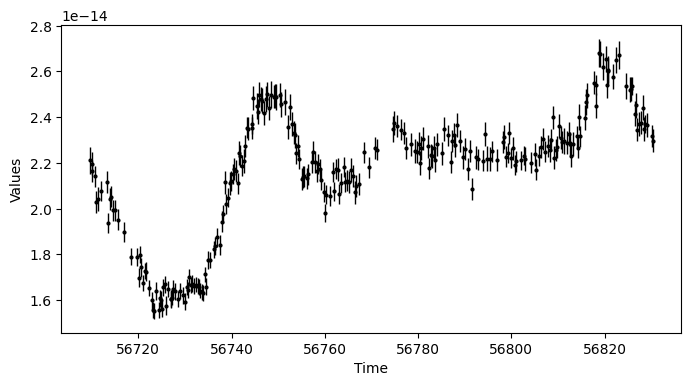

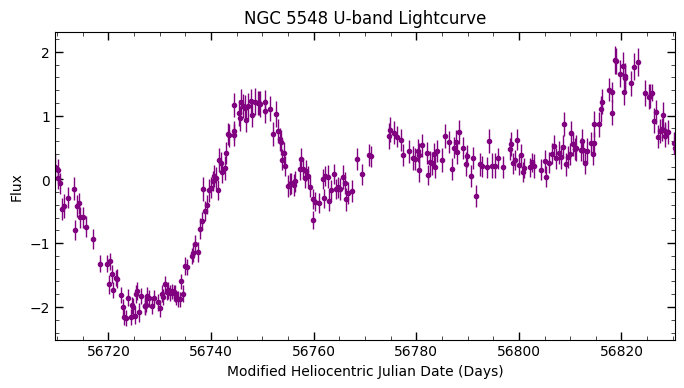

Removed 155 NaN values.NaN values: [False False False ... False False False], NaN errors: [False False False ...  True  True  True]


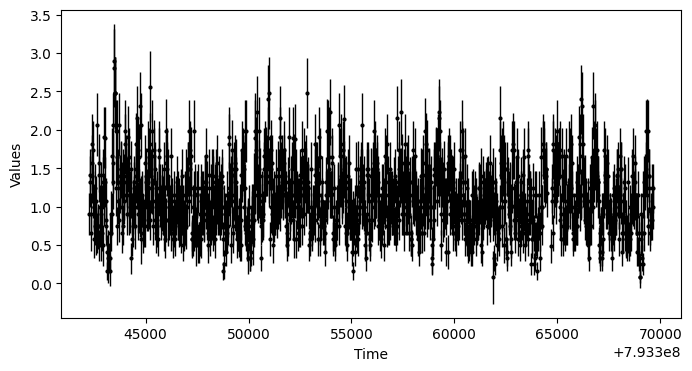

In [ ]:
 ### Import data

# Import from file directly
file_path = '/home/clewin/projects/tsi-toolkit/data/'
lightcurve = TimeSeries(file_path = f'{file_path}NGC5548_U_swift.dat')

# Import from array
data = np.genfromtxt(f'{file_path}NGC5548_U_swift.dat')
lightcurve = TimeSeries(times=data[:,0], values=data[:,1], errors=data[:,2])

# Plot takes in several common matplotlib arguments to add some flair
lightcurve.plot()

# Plot with custom arguments
# the U-band is around 3500 angstroms, and ultraviolet, so let's make the plot violet
lightcurve.standardize()
lightcurve.plot(figsize=(8,4),
                xlabel='Modified Heliocentric Julian Date (Days)', 
                ylabel='Flux',
                xlim = (lightcurve.times[0], lightcurve.times[-1]),
                title='NGC 5548 U-band Lightcurve',
                fig_kwargs={'linewidth':28},
                plot_kwargs={'color':'purple', 'fmt':'o', 'lw':1, 'ms':3},
                major_tick_kwargs={'direction':'in', 'top':True, 'right':True, 'length':6, 'width':1},
                minor_tick_kwargs={'direction':'in', 'top':True, 'right':True, 'length':3, 'width':0.5},
                )

lightcurve.unstandardize()

# Testing fits loading, but THIS DATA IS NOT PUBLIC COLLIN DO NOT LET IT TOUCH THE GIT WORLD

fits_file = '~/PN_0915390701_2.0-10.0_20s.lc'
lightcurve = TimeSeries(file_path = fits_file, clean_data=True, verbose=True)
lightcurve.plot()